In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Get the words
words = open('/content/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
# Mappings to and from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
# Use words to build the dataset

block_size = 3  # Context Length
X, Y = [], []
for w in words:
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '----->', itos[ix])
    context = context[1:] + [ix]  # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
# Build the dataset

def build_dataset(words):
  block_size =3 # Context length
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182778, 3]) torch.Size([182778])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [ ]:
Xtr.shape, Ytr.shape

(torch.Size([182778, 3]), torch.Size([182778]))

In [ ]:
# In the paper, 17000 words are represented using a 30-D space.
# We have just 27 characters. AK starts with using a simple 2-D space to
# represent them.

C = torch.randn((27, 2))
C

tensor([[ 0.5242,  0.3471],
        [-0.3751,  1.6128],
        [-1.4869, -0.2282],
        [ 1.3098, -3.4718],
        [-1.9895, -0.5846],
        [ 0.0137,  1.6675],
        [-0.8425,  1.0123],
        [ 0.3527, -0.3026],
        [ 1.4915, -1.0367],
        [ 0.2906, -1.6479],
        [-1.0943, -0.7677],
        [ 0.6069, -0.5038],
        [-0.8228, -0.1877],
        [-0.6535, -0.3282],
        [-2.1642, -1.0815],
        [-0.3118,  0.8647],
        [-1.9874, -1.0364],
        [ 0.3282, -1.6353],
        [-0.8019,  0.2097],
        [-1.1787,  0.1889],
        [ 0.1537,  0.5801],
        [-0.1622,  1.4642],
        [-1.3799, -3.0600],
        [-0.0437,  1.3423],
        [-0.5259, -1.5664],
        [ 0.2382, -1.3025],
        [-2.5795, -0.9315]])

In [ ]:
# 2-D representation of the 5th input sample
C[5]

tensor([0.0137, 1.6675])

In [ ]:
# We could get the embedding either like that
# or use the dot-product of the one-hot encoding of the input sample
# and the embedding space.
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([0.0137, 1.6675])

In [ ]:
# A character has a 2-D representation.
# How does the embedding of a context (made of 3 characters) look like?
# Is it simply a concatenation of the 3 2-D embeddings? (essentially a 1 x 6 tensor)
C[torch.tensor([5, 6, 7])]

tensor([[ 0.0137,  1.6675],
        [-0.8425,  1.0123],
        [ 0.3527, -0.3026]])

In [ ]:
# For every one of the 32 input samples, we have a 3x2 embedding
# That is what C[X] gives us.
C[X].shape

torch.Size([228146, 3, 2])

In [ ]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [ ]:
# The above was the first layer

# First hidden layer
# We decided to go with 100 neurons in this layer.
# Each neuron has 6 inputs, so 6 weights making it 6 x 100
W1 = torch.randn((6, 100))

# Each neuron has a bias, so b1 is 1 x 100 in size.
b1 = torch.randn((100))

In [ ]:
# To find the activation, we generally take the dot-product between
# emb and W and add b1. Essentially, something like emb @ W1 + b1
# But it should be noted that emb is of the dimensions 32 x 3 x 2, and
# dimensions of W1 is 6 x 100. So, they are not compatible for a dot-product.
#
# Essentially, what we need is each of the 32 input samples should have a
# 1 x 6 embedding. So, if emb (32 x 3 x 2) can somehow be represented as
# a (32 x 6), we are good to go. The 3 x 2 matrix needs to be squashed into a
# simple 1 x 6 matrix.
#
# What are the best ways to do it in torch? AK gives a number of approaches, 19:40
#
# Intuitively, the 3 x 2 matrix needs to be concatenated resulting in a 1 x 6 matrix.

In [ ]:
# PyTorch Internals by Edward Z. Yang: https://blog.ezyang.com/2019/05/pytorch-internals/

In [ ]:
emb.view(emb.shape[0], 6)     # Does exactly what we want, in a very efficient way

tensor([[ 0.5242,  0.3471,  0.5242,  0.3471,  0.5242,  0.3471],
        [ 0.5242,  0.3471,  0.5242,  0.3471,  0.0137,  1.6675],
        [ 0.5242,  0.3471,  0.0137,  1.6675, -0.6535, -0.3282],
        ...,
        [-2.5795, -0.9315, -2.5795, -0.9315,  0.2382, -1.3025],
        [-2.5795, -0.9315,  0.2382, -1.3025, -2.5795, -0.9315],
        [ 0.2382, -1.3025, -2.5795, -0.9315, -0.5259, -1.5664]])

In [ ]:
# Continuing with our dot product for activation
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) # The addition of b1 is enabled through broadcasting.

In [ ]:
h.shape

# We have 100 activations(one for each neuron) for each of the 32 input samples.

torch.Size([228146, 100])

In [ ]:
# Final Layer
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [ ]:
# Softmax
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

In [ ]:
prob.shape

# We now have the outputs of the neural network

torch.Size([228146, 27])

In [ ]:
# Find the loss function (Mean Negative Log Likelihood)
#loss = -prob[torch.arange(32), Y].log().mean()
#loss

In [ ]:
# Putting everything together
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [ ]:
# Model Construction
g = torch.Generator().manual_seed(2147483647)

# Embeddings
C = torch.randn((27, 10), generator=g)

# L1: Hidden Layer
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)

# L2: Output Layer
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters)

11897

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
# for _ in range(1000):

#   # Forward Pass
#   emb = C[X]    # (32, 3, 2)
#   embcat = emb.view(-1, 6)  # (32, 6)
#   h = torch.tanh(embcat @ W1 + b1)
#   logits = h @ W2 + b2
#   loss = F.cross_entropy(logits, Y)
#   print(loss.item())

#   # Backward Pass
#   for p in parameters:
#     p.grad = None

#   loss.backward()

#   # Update
#   for p in parameters:
#     p.data += -0.1 * p.grad

In [ ]:
# # Finding the right learning rate
# lre = torch.linspace(-3, 0, 1000)
# lrs = 10**lre
# lrs
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(200000):

  # Create a batch
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # Forward Pass
  emb = C[X[ix]]    # (32, 3, 2)
  embcat = emb.view(-1, 30)  # (32, 6)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  # print(loss.item())

  # Backward Pass
  for p in parameters:
    p.grad = None

  loss.backward()

  # Update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr  * p.grad

  # # Track stats
  # lri.append(lre[i])
  # lossi.append(loss.item())
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

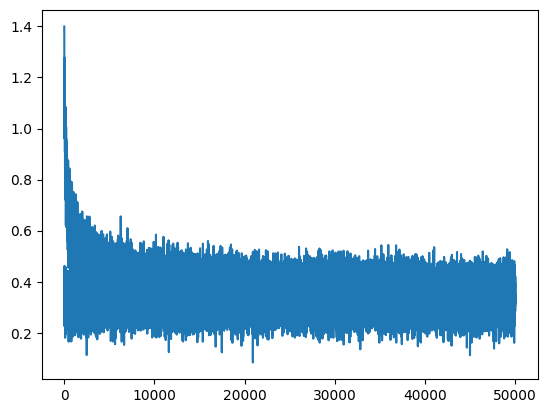

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
#plt.plot(lri, lossi)

In [ ]:
# Data Splits: Training, Dev/Validation, Test splits
# 80%, 10%, 10%
# Training Split: 80% - Optimize the parameters of the model
# Dev Split: 10% - To optimize/find out the hyperparameters of the model
#   1. Learning Rate
#   2. Embedding Size
#.  3. Regularization
# Test Split: Used to evaluate the performance at the end

In [ ]:
# Training split
emb = C[Xtr]    # (32, 3, 2)
embcat = emb.view(-1, 30)
h = torch.tanh(embcat @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1090, grad_fn=<NllLossBackward0>)

In [ ]:
# Dev Split
emb = C[Xdev]    # (32, 3, 2)
embcat = emb.view(-1, 30)
h = torch.tanh(embcat @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4222, grad_fn=<NllLossBackward0>)

In [ ]:
# The model is performing better on the training split than the
# the unseen dev-split. Signs of over-fitting.

# When we are trying to improve the model, check all the hyperparameters and see
# if any of them are the problems/causing bottlenecks.
# 1. Embedding size (There are close to 2.8 lakh input samples, but we use
# a simple 2-D embedding. Maybe we need a higher dimension space to clearly
# represent all the 2.8 lakh samples?!)
# 2. Learning Rate (just to ensure we don't jump the gun and run over the local minima)
# 3. and so on.

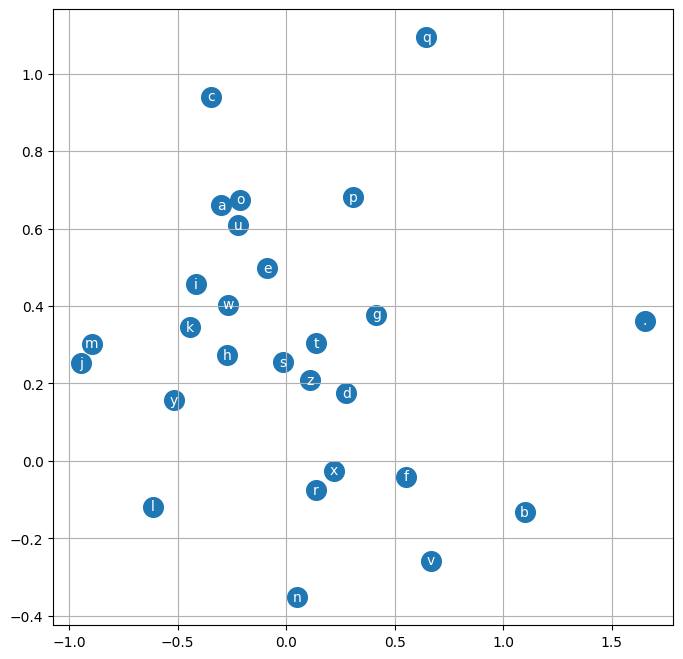

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [ ]:
# Sampling from the model (Generating characters and word-names)
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size  # initialize with all

  while True:
    emb = C[torch.tensor([context])]
    embcat = emb.view(1, -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)

    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

mora.
mayah.
see.
med.
rylla.
emman.
endra.
grace.
kaielin.
shyanelle.
elisananar.
kayzion.
kalin.
shravriah.
mie.
trinie.
jennix.
teriff.
brence.
ryyah.
